<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20250107%5D%20FedAvg-DL%20with%20MLP-LSTM%20model%20on%20WSN-DS%20with%20early%20stopped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FedAvg-DL // MLP-LSTM model 5 classes on WSN-DS**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical

In [ ]:
# Load dataset
dataset = pd.read_csv("dataset_WSN-DS.csv") #WSN-DS 5 classes dataset

# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values

In [ ]:
dataset

,id,Time,Is_CH,who CH,Dist_To_CH,ADV_S,ADV_R,JOIN_S,JOIN_R,SCH_S,SCH_R,Rank,DATA_S,DATA_R,Data_Sent_To_BS,dist_CH_To_BS,send_code,Expaned Energy,Class
0,101000,50,1,101000,0.00000,1,0,0,25,1,0,0,0,1200,48,130.08535,0,2.46940,0
1,101001,50,0,101044,75.32345,0,4,1,0,0,1,2,38,0,0,0.00000,4,0.06957,0
2,101002,50,0,101010,46.95453,0,4,1,0,0,1,19,41,0,0,0.00000,3,0.06898,0
3,101003,50,0,101044,64.85231,0,4,1,0,0,1,16,38,0,0,0.00000,4,0.06673,0
4,101004,50,0,101010,4.83341,0,4,1,0,0,1,25,41,0,0,0.00000,3,0.06534,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374656,201096,1003,0,201051,6.98337,0,5,1,0,0,1,7,96,0,67,170.14779,3,0.15974,0
374657,201097,1003,0,201037,29.32867,0,5,1,0,0,1,31,39,0,24,82.21043,2,0.06877,0
374658,201098,1003,0,201095,18.51963,0,5,1,0,0,1,17,55,0,31,139.26438,1,0.09437,0
374659,201099,1003,0,201051,8.55001,0,5,1,0,0,1,3,96,0,65,158.27492,3,0.16047,0


**Data Preprocessing**

In [ ]:
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']

In [ ]:
print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [340066  14596  10049   6638   3312]


In [ ]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
!pip install -U imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.4
    Uninstalling imbalanced-learn-0.12.4:
      Successfully uninstalled imbalanced-learn-0.12.4


**Data Balancing utilized SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [340066 340066 340066 340066 340066]


**Split data into 80% Training and 20% Testing**

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

**The hybrid MLP + LSTM model**

In [ ]:
from keras.regularizers import l2

# Convert target to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define the hybrid MLP + LSTM model with regularization and other techniques to reduce overfitting
def build_hybrid_model(input_shape, num_classes):
    model = Sequential()

    # MLP layers with L2 regularization
    model.add(Dense(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Increased dropout
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))

    # Dense layers for final feature extraction
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Build and compile the model
input_shape = (X_train.shape[1], )
num_classes = y_train.shape[1]
model = build_hybrid_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 91s 2ms/step - accuracy: 0.8836 - loss: 0.4459 - val_accuracy: 0.9009 - val_loss: 0.2806
Epoch 2/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 88s 2ms/step - accuracy: 0.8956 - loss: 0.2984 - val_accuracy: 0.9024 - val_loss: 0.2714
Epoch 3/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step - accuracy: 0.8964 - loss: 0.2893 - val_accuracy: 0.9033 - val_loss: 0.2578
Epoch 4/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 95s 2ms/step - accuracy: 0.8960 - loss: 0.2855 - val_accuracy: 0.8996 - val_loss: 0.2641
Epoch 5/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 95s 2ms/step - accuracy: 0.8954 - loss: 0.2837 - val_accuracy: 0.9025 - val_loss: 0.2586
Epoch 6/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 91s 2ms/step - accuracy: 0.8956 - loss: 0.2837 - val_accuracy: 0.9026 - val_loss: 0.2563
Epoch 7/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 95s 2ms/step - accuracy: 0.8956 - loss: 0.2814 - val_accuracy: 0.9029 - val_loss: 0.2569
Epoch 8/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 93s 2ms/step - accuracy: 

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

Accuracy: 0.9033393518
Precision: 0.9238271900
Recall: 0.9033393518
F1-Score: 0.9001728269


In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

10628/10628 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
Accuracy: 0.9033393518
Precision: 0.9238271900
Recall: 0.9033393518
F1-Score: 0.9001728269


In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[66683  1040     0   169   121]
 [   36 41062 26894     7    14]
 [    0    41 67933    39     0]
 [ 4250   249     4 63511     0]
 [    6     1     0     0 68006]]


In [ ]:
# Detection Rate (Recall for each class)
print("Detection Rates per Class:", recall_score(y_true_classes, y_pred_classes, average=None))

Detection Rates per Class: [0.98044491 0.60373752 0.99882375 0.93379304 0.99989708]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
# Import roc_curve
from sklearn.metrics import roc_curve # This line imports the roc_curve function
from sklearn.metrics import auc # This line imports the auc function
import matplotlib.pyplot as plt # Import the pyplot module from matplotlib as plt

# After training, calculate ROC curves and AUC for each class
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.10f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")

# Save the plot as a high-resolution image
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.close()

# Calculate and print AUC scores for each class
print("\nAUC Scores for each class:")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.10f}")

# Calculate macro-average AUC
macro_roc_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro-average AUC: {macro_roc_auc:.10f}")

<ipython-input-15-c5170017384f>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))



AUC Scores for each class:
Class 0: 0.9935465694
Class 1: 0.9740631613
Class 2: 0.9762841205
Class 3: 0.9942230683
Class 4: 0.9998963825

Macro-average AUC: 0.9876026604


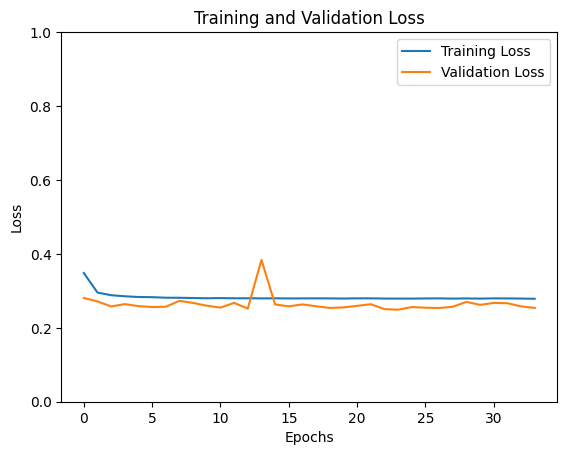

In [ ]:
# Plot Training and Validation Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)  # Set y-axis scale to 1
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="PuBu",
                 vmin=0, vmax=35000, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  ax.yaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  ##plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  ##plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid RF-LSTM Model


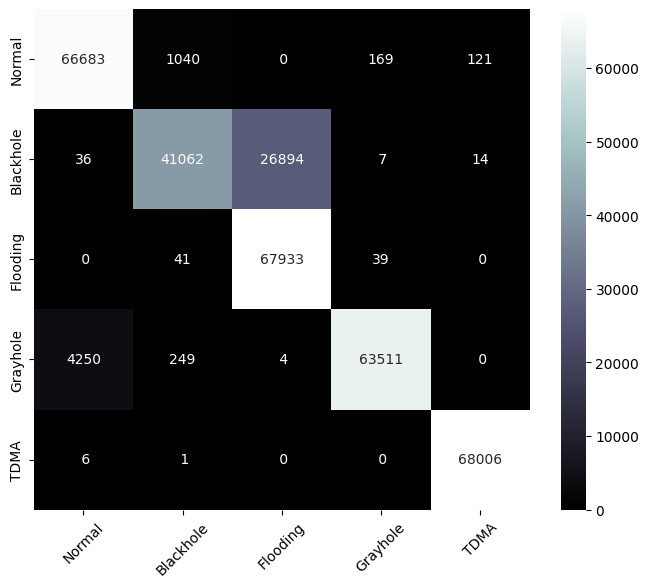

In [ ]:
print("Confusion Matrix of Hybrid RF-LSTM Model")
#conf_mat(np.argmax(y_test, axis=1), test_rf_lstm_predictions)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6.5))
# Use plt.xticks to set custom tick labels
# Using get_xticklabels() to access the current labels and then setting rotation.
plt.xticks(ticks=np.arange(5), labels=['Normal','Blackhole','Flooding','Grayhole','TDMA'], rotation=45)
plt.yticks(ticks=np.arange(5), labels=['Normal','Blackhole','Flooding','Grayhole','TDMA'], rotation=45)
sns.heatmap(conf_matrix, annot=True, fmt='2', cmap='bone',xticklabels=['Normal','Blackhole','Flooding','Grayhole','TDMA'], yticklabels=['Normal','Blackhole','Flooding','Grayhole','TDMA'])
sns.set(font_scale=1)
plt.show() # Display the heatmap

In [ ]:
def conf_mat(d1,d2):
  cm = confusion_matrix(y_true_classes, y_pred_classes)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="gist_yarg",
                 vmin=0, vmax=5600, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=0.85)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  ax.yaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Federated DL// MLP-LSTM Model


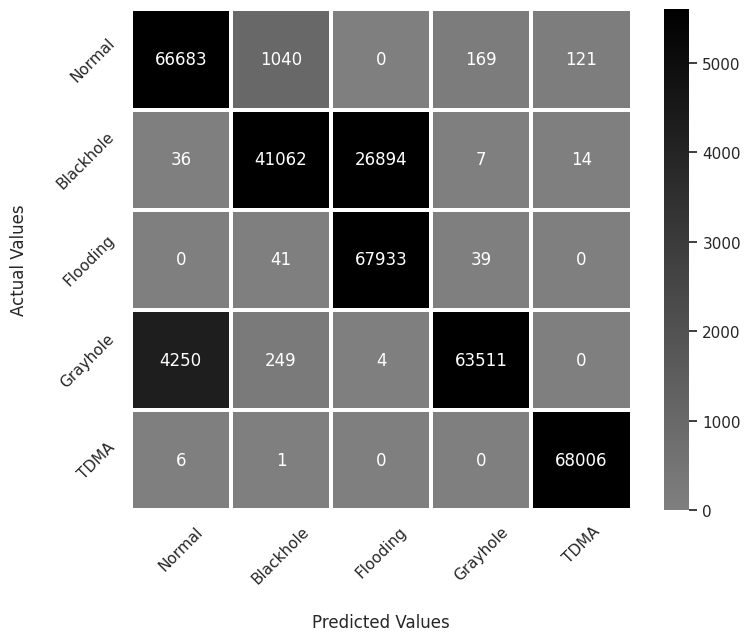

In [ ]:
print("Confusion Matrix of Federated DL// MLP-LSTM Model")
conf_mat(y_true_classes, y_pred_classes)

**Federated Learning Simulation (FedAvg)**

In [ ]:
# Federated Learning Simulation (FedAvg)
def federated_learning_simulation(X_train, y_train, X_test, y_test, num_clients=5):
    # Split training data among clients
    client_data = np.array_split(X_train, num_clients)
    client_labels = np.array_split(y_train, num_clients)

    # Initialize the global model
    global_model = build_hybrid_model(input_shape, num_classes)
    global_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Compile the global model
    global_weights = global_model.get_weights()

    for round in range(10):  # Simulate 10 communication rounds
        local_weights = []

        for i in range(num_clients):
            local_model = build_hybrid_model(input_shape, num_classes)
            local_model.set_weights(global_weights)
            local_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Compile the local model

            # Train the local model
            local_model.fit(client_data[i], client_labels[i], epochs=1, batch_size=32, verbose=0)
            local_weights.append(local_model.get_weights())

        # Aggregate weights (FedAvg)
        global_weights = [
            np.mean([local_weights[j][i] for j in range(num_clients)], axis=0)
            for i in range(len(global_weights))
        ]
        global_model.set_weights(global_weights)

        # Evaluate the global model
        loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
        print(f"Round {round + 1}: Global Model Accuracy = {acc:.10f}")

# Call the federated learning simulation function
federated_learning_simulation(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Round 1: Global Model Accuracy = 0.8988960981
Round 2: Global Model Accuracy = 0.9011221528
Round 3: Global Model Accuracy = 0.9014338255
Round 4: Global Model Accuracy = 0.9009398222
Round 5: Global Model Accuracy = 0.8986549377
Round 6: Global Model Accuracy = 0.9009898305
Round 7: Global Model Accuracy = 0.9006898403
Round 8: Global Model Accuracy = 0.9011632800
Round 9: Global Model Accuracy = 0.9011868238
Round 10: Global Model Accuracy = 0.9011897445


In [ ]:
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Function to measure model performance
def evaluate_global_model(global_model, X_test, y_test):
    y_pred = global_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Compute performance metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    print("\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy:.10f}")
    print(f"Precision: {precision:.10f}")
    print(f"Recall: {recall:.10f}")
    print(f"F1-Score: {f1:.10f}")
    print("\nConfusion Matrix:")
    print(cm)

    return accuracy, precision, recall, f1

# Function to analyze communication overhead
def analyze_communication_overhead(local_weights, global_weights):
    communication_cost = 0
    for i in range(len(local_weights)):
        # Compute the size of weights transmitted between clients and server
        communication_cost += sum(w.nbytes for w in local_weights[i])
    communication_cost += sum(w.nbytes for w in global_weights)

    print(f"\nCommunication Overhead: {communication_cost / (1024 ** 2):.2f} MB")  # in megabytes

# Federated Learning Simulation (FedAvg)
def federated_learning_simulation(X_train, y_train, X_test, y_test, num_clients=5):
    client_data = np.array_split(X_train, num_clients)
    client_labels = np.array_split(y_train, num_clients)

    global_model = build_hybrid_model(input_shape, num_classes)
    global_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    global_weights = global_model.get_weights()

    communication_overhead = []
    latency_per_round = []

    for round in range(10):  # Simulate 10 communication rounds
        local_weights = []

        start_time = time.time()  # Start measuring latency

        for i in range(num_clients):
            local_model = build_hybrid_model(input_shape, num_classes)
            local_model.set_weights(global_weights)
            local_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

            local_model.fit(client_data[i], client_labels[i], epochs=1, batch_size=32, verbose=0)
            local_weights.append(local_model.get_weights())

        # Aggregate weights (FedAvg)
        global_weights = [
            np.mean([local_weights[j][i] for j in range(num_clients)], axis=0)
            for i in range(len(global_weights))
        ]
        global_model.set_weights(global_weights)

        # Measure latency
        end_time = time.time()
        latency = end_time - start_time
        latency_per_round.append(latency)

        # Measure communication overhead
        analyze_communication_overhead(local_weights, global_weights)

        # Evaluate the global model
        loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
        print(f"\nRound {round + 1}: Global Model Accuracy = {acc:.10f}")

        # Evaluate model performance metrics
        evaluate_global_model(global_model, X_test, y_test)

    # Summarize overall latency
    print("\nLatency Analysis:")
    print(f"Average Latency per Round: {np.mean(latency_per_round):.2f} seconds")
    print(f"Total Latency for 10 Rounds: {np.sum(latency_per_round):.2f} seconds")

# Call the federated learning simulation function
federated_learning_simulation(X_train, y_train, X_test, y_test)


Communication Overhead: 0.30 MB

Round 1: Global Model Accuracy = 0.8737568855
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step

Model Performance Metrics:
Accuracy: 0.8737568590
Precision: 0.8781424954
Recall: 0.8737568590
F1-Score: 0.8752661732

Confusion Matrix:
[[66198  1665     2    67    81]
 [    0 52033 15980     0     0]
 [    0 18058 49955     0     0]
 [ 4225   562  1121 62106     0]
 [    0  1169     0     1 66843]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Communication Overhead: 0.30 MB

Round 2: Global Model Accuracy = 0.8997047544
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step

Model Performance Metrics:
Accuracy: 0.8997047632
Precision: 0.9199699360
Recall: 0.8997047632
F1-Score: 0.8969368364

Confusion Matrix:
[[66198  1626     2    70   117]
 [    0 41221 26773    19     0]
 [    0    69 67944     0     0]
 [ 4226   353   790 62604    41]
 [    0    21     0     0 67992]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Communication Overhead: 0.30 MB

Round 3: Global Model Accuracy = 0.9013015032
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step

Model Performance Metrics:
Accuracy: 0.9013015121
Precision: 0.9197632296
Recall: 0.9013015121
F1-Score: 0.8984750755

Confusion Matrix:
[[66198  1600     0   107   108]
 [    0 41456 26535    22     0]
 [    0   373 67640     0     0]
 [ 4226   293   180 63315     0]
 [    0   120     0     0 67893]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Communication Overhead: 0.30 MB

Round 4: Global Model Accuracy = 0.9014220834
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step

Model Performance Metrics:
Accuracy: 0.9014220769
Precision: 0.9213784225
Recall: 0.9014220769
F1-Score: 0.8984233666

Confusion Matrix:
[[66198  1573     0   132   110]
 [    0 41105 26892    16     0]
 [    0     1 68012     0     0]
 [ 4226   282   264 63242     0]
 [    0    27     0     0 67986]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Communication Overhead: 0.30 MB

Round 5: Global Model Accuracy = 0.9002899528
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step

Model Performance Metrics:
Accuracy: 0.9002899437
Precision: 0.9195337295
Recall: 0.9002899437
F1-Score: 0.8973245999

Confusion Matrix:
[[66240  1541     0   131   101]
 [    4 41085 26924     0     0]
 [    0    74 67939     0     0]
 [ 4226   372   205 63211     0]
 [    0   330     0     0 67683]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Communication Overhead: 0.30 MB

Round 6: Global Model Accuracy = 0.9018014073
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step

Model Performance Metrics:
Accuracy: 0.9018014150
Precision: 0.9216187600
Recall: 0.9018014150
F1-Score: 0.8987779044

Confusion Matrix:
[[66236  1525     0   138   114]
 [    8 41124 26881     0     0]
 [    0    23 67990     0     0]
 [ 4226   286   160 63342     0]
 [    0    33     0     0 67980]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Communication Overhead: 0.30 MB

Round 7: Global Model Accuracy = 0.9018278718
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step

Model Performance Metrics:
Accuracy: 0.9018278805
Precision: 0.9215657490
Recall: 0.9018278805
F1-Score: 0.8987720794

Confusion Matrix:
[[66248  1532     0   132   101]
 [    7 41082 26924     0     0]
 [    0     1 68012     0     0]
 [ 4225   279    93 63417     0]
 [    1    90     0     0 67922]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Communication Overhead: 0.30 MB

Round 8: Global Model Accuracy = 0.9019014239
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step

Model Performance Metrics:
Accuracy: 0.9019013956
Precision: 0.9218586670
Recall: 0.9019013956
F1-Score: 0.8988524500

Confusion Matrix:
[[66314  1467     0   131   101]
 [    8 41080 26925     0     0]
 [    0     0 68013     0     0]
 [ 4226   301   149 63338     0]
 [    1    51     0     0 67961]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Communication Overhead: 0.30 MB

Round 9: Global Model Accuracy = 0.9019513726
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step

Model Performance Metrics:
Accuracy: 0.9019513859
Precision: 0.9219468458
Recall: 0.9019513859
F1-Score: 0.8989153291

Confusion Matrix:
[[66317  1452     0   127   117]
 [    7 41106 26900     0     0]
 [    0     0 68013     0     0]
 [ 4226   310   171 63307     0]
 [    0    33     0     0 67980]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Communication Overhead: 0.30 MB

Round 10: Global Model Accuracy = 0.9013720751
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step

Model Performance Metrics:
Accuracy: 0.9013720866
Precision: 0.9210252086
Recall: 0.9013720866
F1-Score: 0.8983468133

Confusion Matrix:
[[66324  1475     0   113   101]
 [    0 41075 26938     0     0]
 [    0     0 68013     0     0]
 [ 4226   314   138 63336     0]
 [    0   235     0     0 67778]]

Latency Analysis:
Average Latency per Round: 103.74 seconds
Total Latency for 10 Rounds: 1037.42 seconds
